In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
import pymaster as nmt
from importlib import reload
from tqdm import tqdm

In [2]:
nside = 1024
npix = 12*nside**2
lmax = 3*nside-1
l = np.arange(lmax+1)
c2d = l*(l+1) / 2 /np.pi

In [3]:
m_in = 1e6 * hp.ud_grade(hp.read_map(f'npipe6v20_sim/input/ffp10_cmb_143_alm_mc_0205_nside2048_quickpol.fits', field=None), nside)
m_res = 1e6 * hp.ud_grade(hp.read_map(f'npipe6v20_sim/res/residual_npipe6v20_143_0205.fits', field=None), nside)
m_out = m_in + m_res

In [4]:
a_in = hp.anafast(m_in)
a_res = hp.anafast(m_res)
a_out = hp.anafast(m_out)

(5e-05, 10000.0)

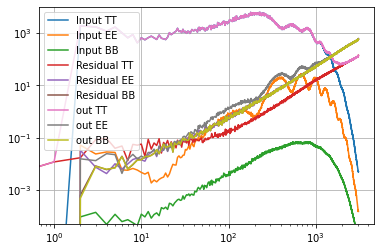

In [5]:
plt.plot(c2d*a_in[0], label='Input TT')
plt.plot(c2d*a_in[1], label='Input EE')
plt.plot(c2d*a_in[2], label='Input BB')

plt.plot(c2d*a_res[0], label='Residual TT')
plt.plot(c2d*a_res[1], label='Residual EE')
plt.plot(c2d*a_res[2], label='Residual BB')

plt.plot(c2d*a_out[0], label='out TT')
plt.plot(c2d*a_out[1], label='out EE')
plt.plot(c2d*a_out[2], label='out BB')

plt.loglog()
plt.grid()
plt.legend()
plt.ylim([5e-5, 1e4])

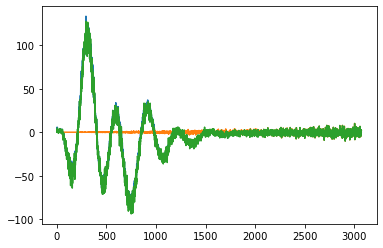

In [6]:
plt.plot(c2d*a_in[3], label='Input TE')
plt.plot(c2d*a_res[3], label='Residual TE')
plt.plot(c2d*a_out[3], label='out TE')

In [7]:
#Multivariate
W_11 = (a_in[1] * a_out[0] - a_in[3]*a_out[3]) / (a_out[1] * a_out[0] - a_out[3]**2)
W_01 = (a_in[3] * a_out[1] - a_in[1]*a_out[3]) / (a_out[1] * a_out[0] - a_out[3]**2)

/tmp/ipykernel_16144/3664176263.py:2: RuntimeWarning: invalid value encountered in true_divide
  W_11 = (a_in[1] * a_out[0] - a_in[3]*a_out[3]) / (a_out[1] * a_out[0] - a_out[3]**2)
/tmp/ipykernel_16144/3664176263.py:3: RuntimeWarning: invalid value encountered in true_divide
  W_01 = (a_in[3] * a_out[1] - a_in[1]*a_out[3]) / (a_out[1] * a_out[0] - a_out[3]**2)


[]

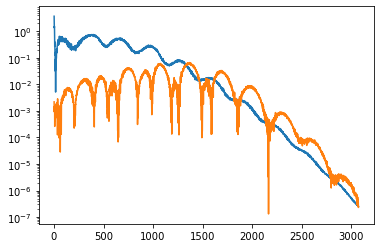

In [8]:
plt.plot(W_11, label='11 (EE)')
plt.plot(np.abs(W_01), label='01 (ET)')
plt.semilogy()

In [9]:
alm_out = hp.map2alm(m_out)
EE_contr = hp.almxfl(alm_out[1], W_11)
TT_contr = hp.almxfl(alm_out[0], W_01)

[]

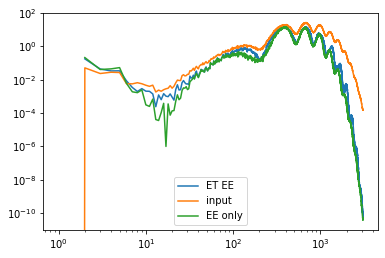

In [10]:
plt.plot(c2d*hp.alm2cl(EE_contr + TT_contr), label='ET EE')
plt.plot(c2d*a_in[1], label='input')
plt.plot(c2d*hp.alm2cl(EE_contr), label='EE only')
plt.legend()
# plt.plot(c2d*a_out[1])
plt.loglog()

In [11]:
#Signal recovered ratio

alm_in = hp.map2alm(m_in)
EE_contr_s = hp.almxfl(alm_in[1], W_11)
TT_contr_s = hp.almxfl(alm_in[0], W_01)

alm_res = hp.map2alm(m_res)
EE_contr_n = hp.almxfl(alm_res[1], W_11)
TT_contr_n = hp.almxfl(alm_res[0], W_01)

signal_rec = (hp.alm2cl(EE_contr, EE_contr_s) + hp.alm2cl(TT_contr, TT_contr_s)) / a_in[1]
noise_remaining = (hp.alm2cl(EE_contr, EE_contr_n) + hp.alm2cl(TT_contr, TT_contr_n)) / a_in[1]

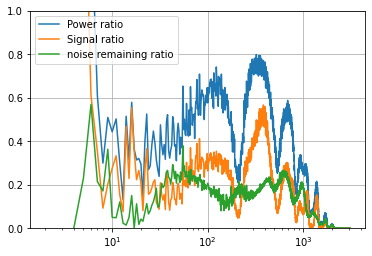

In [12]:
#Power recovered ratio
plt.plot(hp.alm2cl(EE_contr + TT_contr)/a_in[1], label='Power ratio')
# plt.plot(hp.alm2cl(EE_contr)/a_in[1], label='EE')
plt.plot(signal_rec, label='Signal ratio')
plt.plot(noise_remaining, label='noise remaining ratio')

plt.legend()
plt.ylim([0,1])
plt.semilogx()
plt.grid()

/tmp/ipykernel_16144/2059727625.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(a_in[1]/a_res[1])


[]

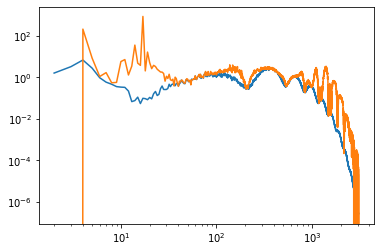

In [13]:
#S/N before and after
plt.plot(a_in[1]/a_res[1])
plt.plot(signal_rec/noise_remaining)
plt.loglog()